In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

In [5]:
data = pd.read_csv('dataset/etherium_TSdata.csv')
data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,14.Sep.15,0.940566,0.95,0.87,0.875622,"741,085","64,084,135"
1,15.Sep.15,0.875189,1.05,0.88,0.94441,"703,390","69,141,409"
2,16.Sep.15,0.941977,0.95,0.90,0.907175,"615,593","66,437,873"
3,17.Sep.15,0.906865,0.91,0.83,0.874231,"897,940","64,046,216"
4,18.Sep.15,0.874574,0.89,0.83,0.853685,"484,622","62,561,883"


## Compute Mid Price

In [6]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

## Create Windows

Window: 50  
최근 50일 데이터를 보고 다음을 예측한다.

In [7]:
seq_len = 10
sequence_length = seq_len + 1

result = []

for index in range(len(mid_prices) - sequence_length):
    #print(index)
    result.append(mid_prices[index: index + sequence_length]) # slicing

## Normalize Data

모델이 잘 예측하게 함. 

### How?

(맨 처음 값 - 해당 값) - 1 -> -1 해주는 이유는 처음 값을 0 으로 만들기 위함

In [8]:
normalized_data = []

for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.95))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1725, 10, 1) (91, 10, 1)
(1725,) (91,)


 ## Build a Model

In [9]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## Training

In [10]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=100)

Epoch 1/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0204 - val_loss: 0.0046
Epoch 2/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 3/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 4/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 9.5345e-04
Epoch 6/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 9.4444e-04
Epoch 7/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 8/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 9/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0035

173/173 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 7.9578e-04
Epoch 80/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 81/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 8.3220e-04
Epoch 82/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 8.3976e-04
Epoch 83/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 8.8319e-04
Epoch 84/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 8.4979e-04
Epoch 85/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 8.2902e-04
Epoch 86/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 9.1250e-04
Epoch 87/100
173/173 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 8.9969e-04
Epoch 88/100
173/173 [==============================] - 1s 6ms/

## Prediction

In [11]:
pred = model.predict(x_test)

# pred / y_test -> 2차원 이되, 일렬 데이터로 변경..
#pred = pred.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)

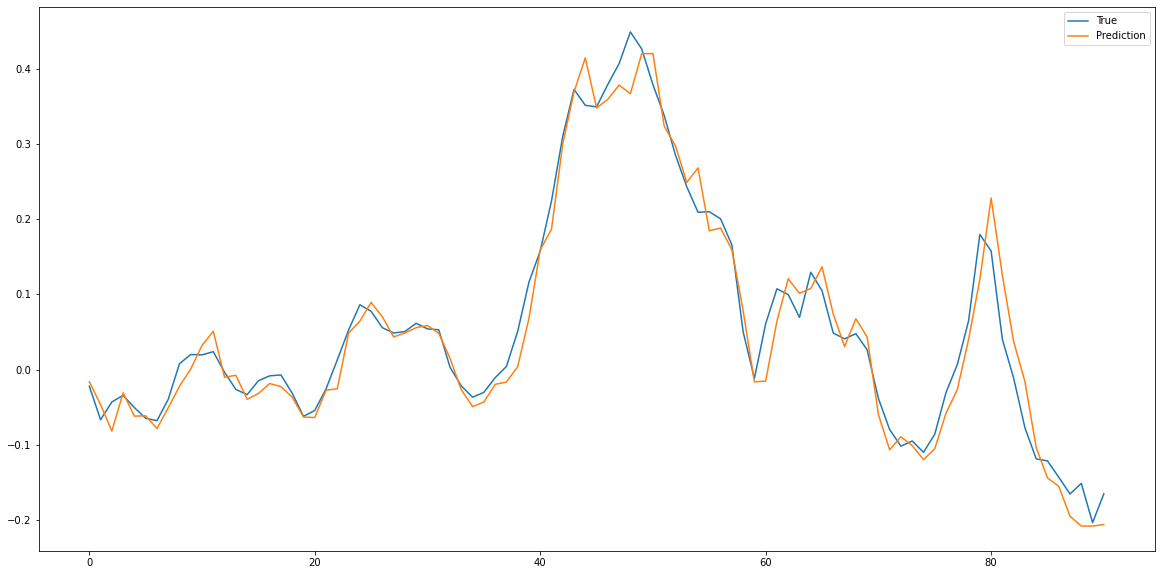

In [12]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

## 10 -> one epoch: 100 val_loss : 0.0007

In [16]:
ax.legend?